# Coefficient field inversion in an elliptic partial differential equation

We consider the estimation of a coefficient in an elliptic partial
differential equation as a first model problem. Depending on the
interpretation of the unknowns and the type of measurements, this
model problem arises, for instance, in inversion for groundwater flow
or heat conductivity.  It can also be interpreted as finding a
membrane with a certain spatially varying stiffness. Let
$\Omega\subset\mathbb{R}^n$, $n\in\{1,2,3\}$ be an open, bounded
domain and consider the following problem:

$$
\min_{m} J(m):=\frac{1}{2}\int_\Omega (u-u_d)^2\, dx + \frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx,
$$

where $u$ is the solution of

$$
\begin{split}
\quad -\nabla\cdot(e^m \nabla u) &= f \text{ in }\Omega,\\
u &= 0 \text{ on }\partial\Omega.
\end{split}
$$

Here $m \in \mathcal{M}:=\{m\in L^{\infty}(\Omega) \bigcap H^1(\Omega)\}$ denotes the unknown coefficient field, 
$u \in \mathcal{V}:= H^1_0(\Omega)$ the state variable, $u_d$ the (possibly noisy) data, $f\in H^{-1}(\Omega)$ a given volume force, and $\gamma\ge 0$ the regularization parameter.

### The variational (or weak) form of the state equation:

Find $u\in \mathcal{V}$ such that 

$$(e^m \nabla u,\nabla v) - (f,v) = 0, \text{ for all } v\in \mathcal{V},$$

where $\mathcal{V} := H_0^1(\Omega)$ is the space of functions vanishing on $\partial\Omega$ with square integrable derivatives. 

Above, $(\cdot\,\cdot)$ denotes the $L^2$-inner product, i.e, for scalar functions $u,v$ defined on $\Omega$ we write 

$$(u,v) := \int_\Omega u(x) v(x) \,dx, $$

and similarly for vector functions $\boldsymbol{u}, \boldsymbol{v}$ defined on $\Omega$ we write

$$(\boldsymbol{u},\boldsymbol{v}) := \int_\Omega \boldsymbol{u}(x) \cdot \boldsymbol{v}(x) \,dx.$$

### Gradient evaluation:

The Lagrangian functional $\mathscr{L}:\mathcal{V}\times\mathcal{M}\times\mathcal{V}\rightarrow \mathbb{R}$ is given by

$$
\mathscr{L}(u,m,p):= \frac{1}{2}(u-u_d,u-u_d) +
\frac{\gamma}{2}(\nabla m, \nabla m) +  (e^m\nabla u,\nabla p) - (f,p).
$$

Then the gradient of the cost functional $\mathcal{J}(m)$ with respect to the parameter $m$ is

$$
    \mathcal{G}(m)(\tilde m) := \mathscr{L}_m(u,m,p)(\tilde{m}) = \gamma(\nabla m, \nabla \tilde{m}) +
     (\tilde{m}e^m\nabla u, \nabla p) \quad \forall \tilde{m} \in \mathcal{M},
$$

where $u \in H_0^1(\Omega)$ is the solution of the forward problem,

$$ \mathscr{L}_p(u,m,p)(\tilde{p})  := (\exp(m)\nabla u, \nabla \tilde{p}) - (f,\tilde{p}) = 0
\quad \forall \tilde{p} \in \mathcal{V}, $$

and $p \in H_0^1(\Omega)$ is the solution of the adjoint problem,

$$ \mathscr{L}_u(u,m,p)(\tilde{u}) := (\exp(m)\nabla p, \nabla \tilde{u}) + (u-u_d,\tilde{u}) = 0
\quad \forall \tilde{u} \in \mathcal{V}.$$

### Steepest descent method

Written in abstract form, the steepest descent method computes an update direction $\hat{m}_k$ in the direction of the negative gradient defined as 

$$
(\tilde{m}, \hat{m}_k ) = -\mathcal{G}(m_k)(\tilde m) \quad \forall \tilde{m} \in H^1(\Omega),
$$

where the evaluation of the gradient $\mathcal{G}(m_k)$ involves the solution $u_k$ and $p_k$ of the forward and adjoint problems (respectively) for $m = m_k$.

Then we set $m_{k+1} = m_k + \alpha \hat{m}_k$, where the step length $\alpha$ is chosen to guarantee sufficient descent. 

### Import dependencies

In [2]:
from __future__ import print_function, division, absolute_import

import matplotlib.pyplot as plt
%matplotlib inline

import dolfin as dl
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_DIR', "../../") )

from hippylib import nb

import numpy as np
import logging


logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

### Model set up:

As in the introduction, the first thing we need to do is to set up the numerical model.

In this cell, we set the mesh ``mesh``, the finite element spaces ``Vm`` and ``Vu`` corresponding to the parameter space and state/adjoint space, respectively. In particular, we use linear finite elements for the parameter space, and quadratic elements for the state/adjoint space.

The true parameter ``mtrue`` is the finite element interpolant of the function

$$ m_{\rm true} = \left\{ \begin{array}{l} \ln 4 \; \forall \,(x,y) \, {\rm s.t.}\, \sqrt{ (x-.5)^2 + (y-.5)^2} \leq 0.2 \\ \ln 8 \; {\rm otherwise}. \end{array}\right. $$

The forcing term ``f`` and the boundary conditions ``u0`` for the forward problem are

$$ f = 1 \; \forall {\bf x} \in \Omega, \quad u = 0 \; \forall {\bf x} \in \partial \Omega. $$

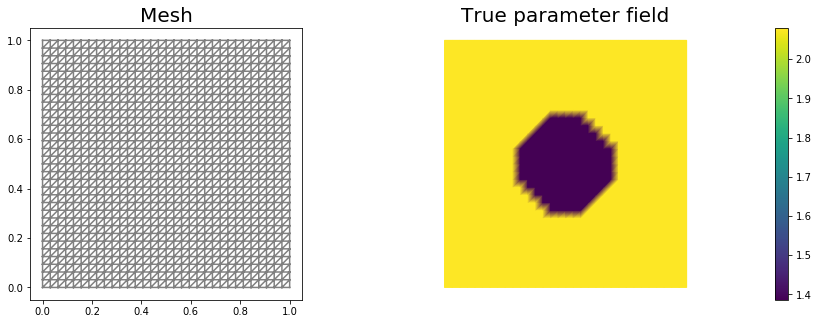

In [3]:
# create mesh and define function spaces
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and initial guess for inverted parameter
mtrue = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
f  = dl.Constant(1.0)
u0 = dl.Constant(0.0)

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh, subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue, subplot_loc=122, mytitle="True parameter field")
plt.show()

In [4]:
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary

bc_state = dl.DirichletBC(Vu, u0, boundary)
bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

### Set up synthetic observations:

To generate the synthetic observation we first solve the PDE for the state variable ``utrue`` corresponding to the true parameter ``mtrue``.
Specifically, we solve the variational problem

Find $u\in \mathcal{V}$ such that 

$$\underbrace{(e^{m_{\text true}} \nabla u,\nabla v)}_{\; := \; a_{\rm true}} - \underbrace{(f,v)}_{\; := \;L_{\rm true}} = 0, \text{ for all } v\in \mathcal{V}$$.

Then we perturb the true state variable and write the observation ``ud`` as

$$ u_{d} = u_{\rm true} + \eta, \quad {\rm where} \; \eta \sim \mathcal{N}(0, \sigma^2).$$

Here the standard variation $\sigma$ is proportional to ``noise_level``.

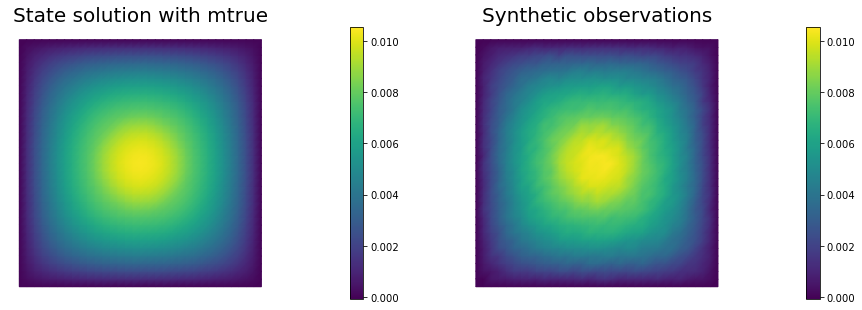

In [5]:
# noise level
noise_level = 0.01

# weak form for setting up the synthetic observations
a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_true = f * u_test * dl.dx

# solve the forward/state problem to generate synthetic observations
A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

utrue = dl.Function(Vu)
dl.solve(A_true, utrue.vector(), b_true)

ud = dl.Function(Vu)
ud.assign(utrue)

# perturb state solution and create synthetic measurements ud
# ud = u + ||u||/SNR * random.normal
MAX = ud.vector().norm("linf")
noise = dl.Vector()
A_true.init_vector(noise,1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
bc_adj.apply(noise)

ud.vector().axpy(1., noise)

# plot
nb.multi1_plot([utrue, ud], ["State solution with mtrue", "Synthetic observations"])
plt.show()

### The cost functional evaluation:

$$
J(m):=\underbrace{\frac{1}{2}\int_\Omega (u-u_d)^2\, dx}_{\text misfit} + \underbrace{\frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx}_{\text reg}
$$

In [6]:
# Regularization parameter
gamma = 1e-9

# Define cost function
def cost(u, ud, m, gamma):
    reg = 0.5*gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx ) 
    misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
    return [reg + misfit, misfit, reg]

### Setting up the variational form for the state/adjoint equations and gradient evaluation

Below we define the variational forms that appear in the the state/adjoint equations and gradient evaluation.

Specifically,

- `a_state`, `L_state` stand for the bilinear and linear forms of the state equation, repectively;
- `a_adj`, `L_adj` stand for the bilinear and linear forms of the adjoint equation, repectively;
- `CTvarf`, `gradRvarf` stand for the contributions to the gradient coming from the PDE and the regularization, respectively.

We also build the *mass* matrix $M$ that is used to discretize the $L^2(\Omega)$ inner product.

In [7]:
# weak form for setting up the state equation
a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_state = f * u_test * dl.dx

# weak form for setting up the adjoint equations
a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx
L_adj = - dl.inner(u - ud, p_test) * dl.dx

# weak form for gradient
CTvarf    = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

# Mass matrix in parameter space
Mvarf    = dl.inner(m_trial, m_test) * dl.dx
M = dl.assemble(Mvarf)

### Finite difference check of the gradient

We use a **finite difference check** to verify that our gradient derivation is correct.
Specifically, we consider a function $ m_0\in \mathcal{M}$ and we verify that for an arbitrary direction $\tilde{m} \in \mathcal{M}$ we have
$$ r := \left| \frac{ \mathcal{J}(m_0 + \varepsilon \tilde{m}) - \mathcal{J}(m_0)}{\varepsilon} -  \mathcal{G}(m_0)(\tilde{m})\right| = \mathcal{O}(\varepsilon).$$

In the figure below we show in a loglog scale the value of $r$ as a function of $\varepsilon$. We observe that $r$ decays linearly for a wide range of values of $\varepsilon$, however we notice an increase in the error for extremely small values of $\varepsilon$ due to numerical stability and finite precision arithmetic.


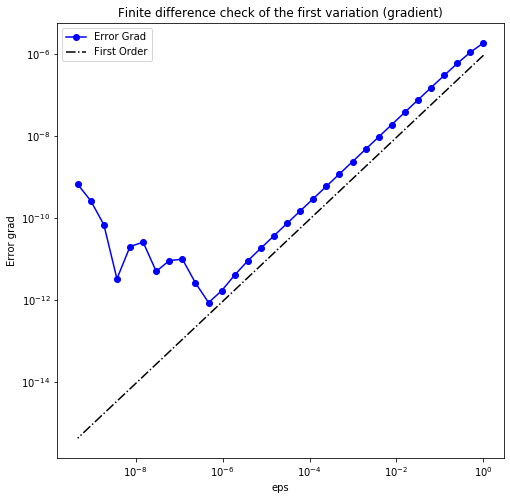

In [8]:
m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )

n_eps = 32
eps = np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m.assign(m0)

#Solve the fwd problem and evaluate the cost functional
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

c0, _, _ = cost(u, ud, m, gamma)

# Solve the adjoint problem and evaluate the gradient
adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
dl.solve(adj_A, p.vector(), adjoint_RHS)

# evaluate the  gradient
grad0 = dl.assemble(CTvarf + gradRvarf)

# Define an arbitrary direction m_hat to perform the check 
mtilde = dl.Function(Vm).vector()
mtilde.set_local(np.random.randn(Vm.dim()))
mtilde.apply("")
mtilde_grad0 = grad0.inner(mtilde)

for i in range(n_eps):
    m.assign(m0)
    m.vector().axpy(eps[i], mtilde)
    
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    cplus, _, _ = cost(u, ud, m, gamma)
   
    err_grad[i] = abs( (cplus - c0)/eps[i] - mtilde_grad0 )

plt.figure(figsize = (8,8))    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

### Initial guess

We solve the state equation and compute the cost functional for the initial guess of the parameter ``m0``

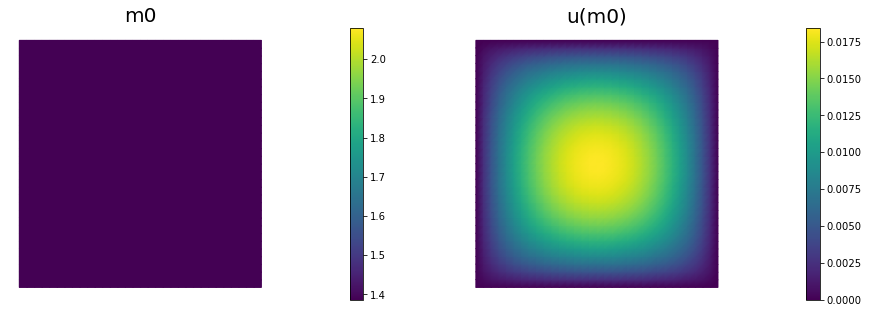

In [9]:
m.assign(m0)

# solve state equation
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

# evaluate cost
[cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)

# plot
plt.figure(figsize=(15,5))
nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
nb.plot(u,subplot_loc=122, mytitle="u(m0)")
plt.show()

## The steepest descent with Armijo line search:

We solve the constrained optimization problem using the steepest descent method with Armijo line search.

The stopping criterion is based on a relative reduction of the norm of the gradient (i.e. $\frac{\|g_{n}\|}{\|g_{0}\|} \leq \tau$).

The gradient is computed by solving the state and adjoint equations for the current parameter $m$, and then substituing the current state $u$, parameter $m$ and adjoint $p$ variables in the weak form expression of the gradient:

$$ (g, \tilde{m}) = \gamma(\nabla m, \nabla \tilde{m}) +(\tilde{m}e^m\nabla u, \nabla p).$$

The Armijo line search uses backtracking to find $\alpha$ such that a sufficient reduction in the cost functional is achieved.
Specifically, we use backtracking to find $\alpha$ such that:

$$J( m - \alpha g ) \leq J(m) - \alpha c_{\rm armijo} (g,g). $$


Nit  cost          misfit        reg         ||grad||       alpha  N backtrack
  0   5.40435e-09   3.71888e-09   1.68547e-09   1.49684e-08   5.00000e+04     1


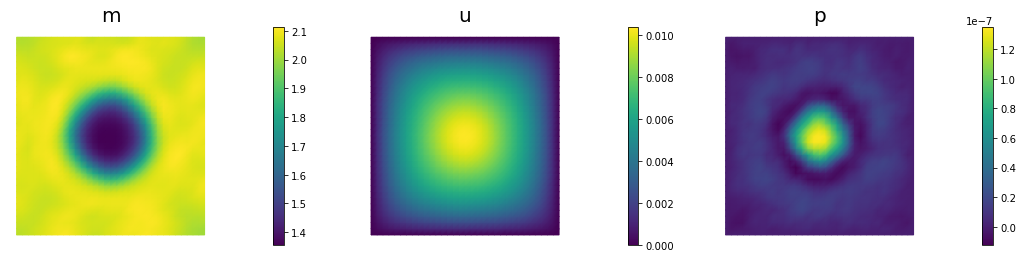

 10   5.39616e-09   3.71812e-09   1.67804e-09   5.20167e-09   5.00000e+04     1
 20   5.39134e-09   3.71951e-09   1.67183e-09   4.46773e-09   5.00000e+04     1
 30   5.38802e-09   3.72058e-09   1.66743e-09   3.84337e-09   5.00000e+04     1
 40   5.38572e-09   3.72145e-09   1.66427e-09   3.30912e-09   5.00000e+04     1
 50   5.38413e-09   3.72216e-09   1.66197e-09   2.85220e-09   5.00000e+04     1


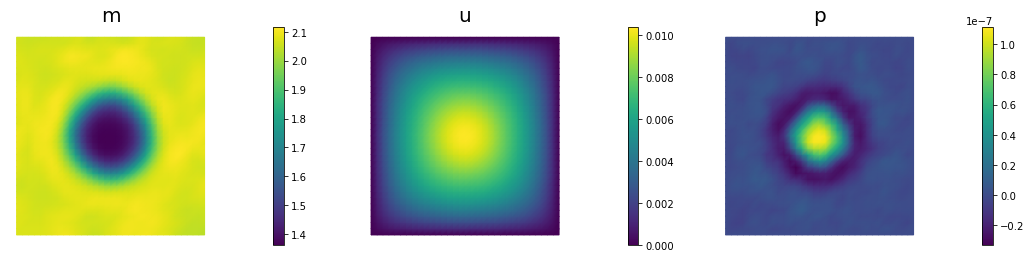

 60   5.38302e-09   3.72275e-09   1.66027e-09   2.46134e-09   5.00000e+04     1
 70   5.38226e-09   3.72324e-09   1.65901e-09   2.12562e-09   5.00000e+04     1
 80   5.38172e-09   3.72365e-09   1.65806e-09   1.83645e-09   5.00000e+04     1
 90   5.38134e-09   3.72399e-09   1.65735e-09   1.58748e-09   5.00000e+04     1
100   5.38108e-09   3.72427e-09   1.65681e-09   1.37310e-09   5.00000e+04     1


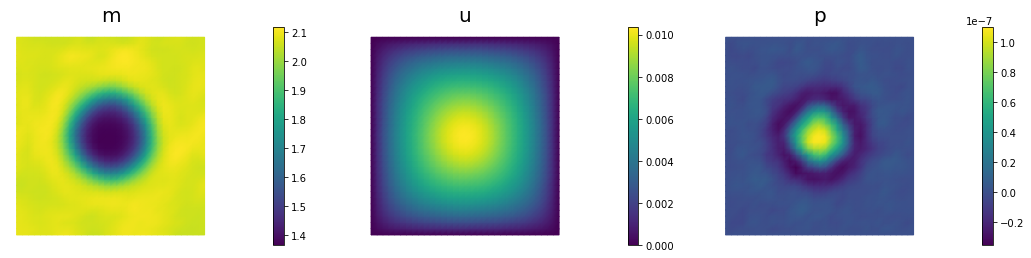

110   5.38090e-09   3.72450e-09   1.65639e-09   1.18811e-09   5.00000e+04     1
120   5.38077e-09   3.72469e-09   1.65608e-09   1.02837e-09   5.00000e+04     1
130   5.38068e-09   3.72484e-09   1.65583e-09   8.90280e-10   5.00000e+04     1
140   5.38061e-09   3.72497e-09   1.65564e-09   7.70921e-10   5.00000e+04     1
150   5.38057e-09   3.72507e-09   1.65550e-09   6.67708e-10   5.00000e+04     1


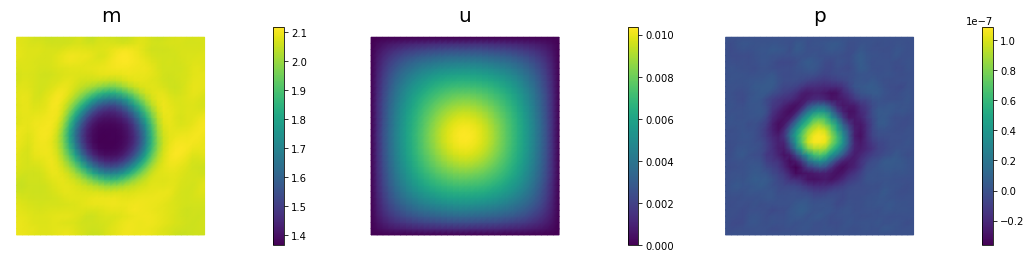

160   5.38053e-09   3.72515e-09   1.65539e-09   5.78457e-10   5.00000e+04     1
170   5.38051e-09   3.72521e-09   1.65530e-09   5.01218e-10   5.00000e+04     1
180   5.38050e-09   3.72526e-09   1.65523e-09   4.34357e-10   5.00000e+04     1
190   5.38048e-09   3.72531e-09   1.65518e-09   3.76466e-10   5.00000e+04     1
200   5.38048e-09   3.72534e-09   1.65514e-09   3.26322e-10   5.00000e+04     1


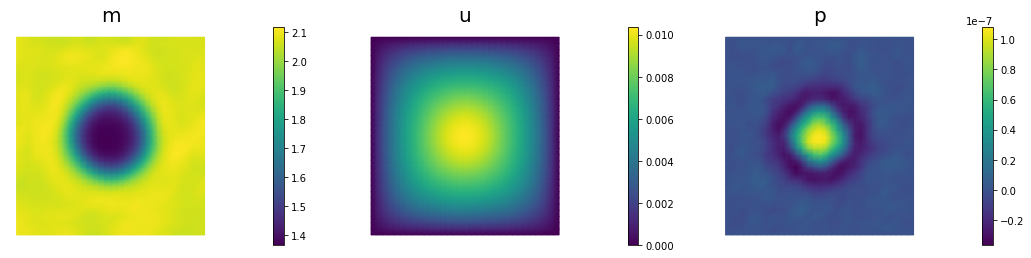

210   5.38047e-09   3.72536e-09   1.65511e-09   2.82890e-10   5.00000e+04     1
220   5.38047e-09   3.72539e-09   1.65508e-09   2.45266e-10   5.00000e+04     1
230   5.38046e-09   3.72540e-09   1.65506e-09   9.35356e-11   1.00000e+05     0
240   5.38046e-09   3.72541e-09   1.65505e-09   8.01404e-11   1.00000e+05     0
250   5.38046e-09   3.72542e-09   1.65503e-09   6.87050e-11   1.00000e+05     0


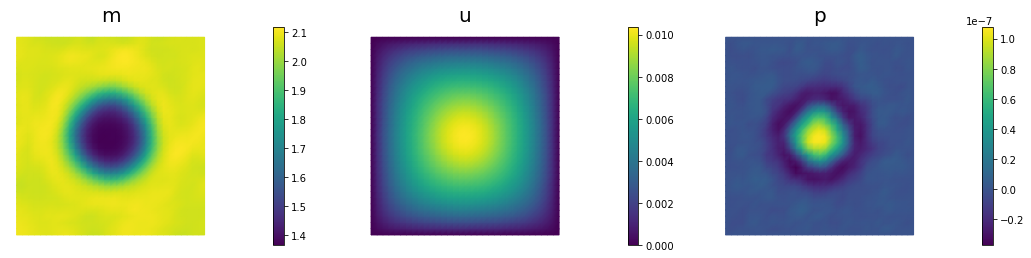

260   5.38046e-09   3.72543e-09   1.65503e-09   5.89351e-11   1.00000e+05     0
270   5.38046e-09   3.72543e-09   1.65502e-09   5.05818e-11   5.00000e+04     1
280   5.38046e-09   3.72544e-09   1.65502e-09   4.34346e-11   5.00000e+04     1
290   5.38046e-09   3.72544e-09   1.65501e-09   3.73154e-11   5.00000e+04     1
300   5.38046e-09   3.72545e-09   1.65501e-09   3.20730e-11   5.00000e+04     1


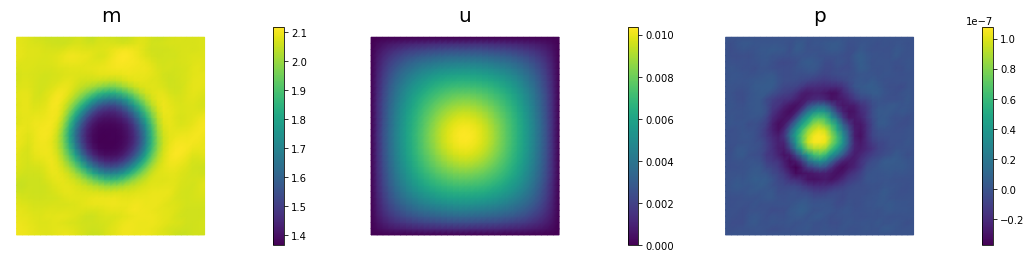

310   5.38046e-09   3.72545e-09   1.65501e-09   2.75792e-11   5.00000e+04     1
320   5.38046e-09   3.72545e-09   1.65500e-09   2.37248e-11   5.00000e+04     1
330   5.38046e-09   3.72545e-09   1.65500e-09   2.04172e-11   5.00000e+04     1
340   5.38046e-09   3.72545e-09   1.65500e-09   1.75773e-11   5.00000e+04     1
350   5.38046e-09   3.72545e-09   1.65500e-09   1.51378e-11   5.00000e+04     1


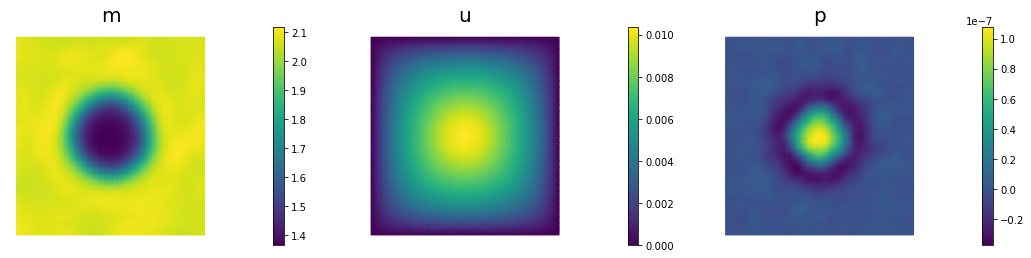

360   5.38046e-09   3.72545e-09   1.65500e-09   1.30413e-11   5.00000e+04     1
370   5.38046e-09   3.72546e-09   1.65500e-09   1.12387e-11   5.00000e+04     1
380   5.38046e-09   3.72546e-09   1.65500e-09   9.68831e-12   5.00000e+04     1
390   5.38046e-09   3.72546e-09   1.65500e-09   8.35424e-12   5.00000e+04     1
400   5.38046e-09   3.72546e-09   1.65500e-09   7.20589e-12   5.00000e+04     1


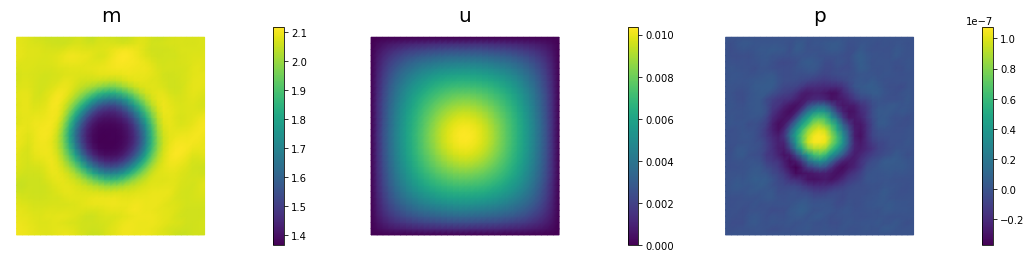

410   5.38046e-09   3.72546e-09   1.65500e-09   6.21707e-12   5.00000e+04     1
420   5.38046e-09   3.72546e-09   1.65500e-09   5.36532e-12   5.00000e+04     1
430   5.38046e-09   3.72546e-09   1.65500e-09   4.63141e-12   5.00000e+04     1
440   5.38046e-09   3.72546e-09   1.65500e-09   3.99883e-12   5.00000e+04     1
450   5.38046e-09   3.72546e-09   1.65500e-09   3.45344e-12   5.00000e+04     1


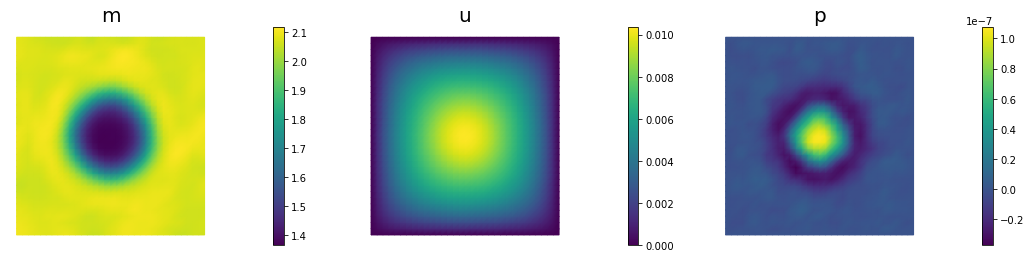

460   5.38046e-09   3.72546e-09   1.65500e-09   2.98309e-12   5.00000e+04     1
470   5.38046e-09   3.72546e-09   1.65500e-09   2.57734e-12   5.00000e+04     1
480   5.38046e-09   3.72546e-09   1.65500e-09   2.22723e-12   5.00000e+04     1
Steepest descent converged in  485   iterations


In [25]:
# define parameters for the optimization
tol = 1e-4
maxiter = 10000
print_any = 10
plot_any = 50
c_armijo = 1e-5

# initialize iter counters
iter = 0
converged = False

# initializations
g = dl.Vector()
M.init_vector(g,0)

m_prev = dl.Function(Vm)

print( "Nit  cost          misfit        reg         ||grad||       alpha  N backtrack" )

while iter <  maxiter and not converged:

    # solve the adoint problem
    adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
    dl.solve(adj_A, p.vector(), adjoint_RHS)

    # evaluate the  gradient
    MG = dl.assemble(CTvarf + gradRvarf)
    dl.solve(M, g, MG)

    # calculate the norm of the gradient
    grad_norm2 = g.inner(MG)
    gradnorm = np.sqrt(grad_norm2)
    
    if iter == 0:
        gradnorm0 = gradnorm

    # linesearch
    it_backtrack = 0
    m_prev.assign(m)
    alpha = 1.e5
    backtrack_converged = False
    for it_backtrack in range(20):
        
        m.vector().axpy(-alpha, g )

        # solve the state/forward problem
        state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
        dl.solve(state_A, u.vector(), state_b)

        # evaluate cost
        [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old - alpha * c_armijo * grad_norm2:
            cost_old = cost_new
            backtrack_converged = True
            break
        else:
            alpha *= 0.5
            m.assign(m_prev)  # reset a
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break

    sp = ""
    if (iter % print_any)== 0 :
        print( "%3d %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %3d" % \
            (iter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
            gradnorm, sp, alpha, sp, it_backtrack) )

    if (iter % plot_any)== 0 :
        nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        plt.show()
    
    # check for convergence
    if gradnorm < tol*gradnorm0 and iter > 0:
        converged = True
        print ("Steepest descent converged in ",iter,"  iterations")
        
    iter += 1
    
if not converged:
    print ( "Steepest descent did not converge in ", maxiter, " iterations")

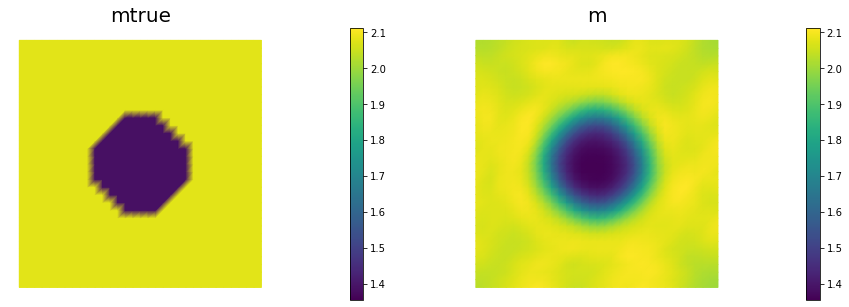

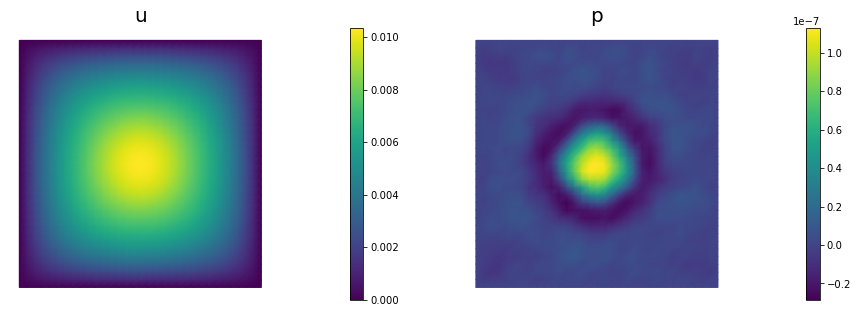

In [11]:
nb.multi1_plot([mtrue, m], ["mtrue", "m"])
nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
plt.show()

## Another example: advection-diffusion problem

$\def\bv{{\bf v}}$

We modify the problem above by adding an advective term with $\bv = (30,0)^T$:

$$
\begin{split}
\quad -\nabla\cdot(e^m\nabla u)  + \bv \cdot \nabla u &= f \text{ in }\Omega,\\
u &= 0 \text{ on }\partial\Omega.
\end{split}
$$

In [26]:
def AddDiffInverseProblem(nx, ny, v, gamma, useTV=False, TVeps=None, plotting=False):
    np.random.seed(seed=1)
    mesh = dl.UnitSquareMesh(nx, ny)
    Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
    Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

    # The true and initial guess for inverted parameter
    mtrue = dl.interpolate(
            dl.Expression('std::log( 8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5),
                            Vm)

    # define function for state and adjoint
    u = dl.Function(Vu)
    m = dl.Function(Vm)
    p = dl.Function(Vu)

    # define Trial and Test Functions
    u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
    u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

    # initialize input functions
    f  = dl.Constant(1.0)
    u0 = dl.Constant(0.0)
    
    # set up dirichlet boundary conditions
    def boundary(x,on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vu, u0, boundary)
    bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), boundary)
    
    # noise level
    noise_level = 0.01

    # weak form for setting up the synthetic observations
    a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx \
            + dl.dot(v, dl.grad(u_trial))*u_test*dl.dx
    L_true = f * u_test * dl.dx

    # solve the forward/state problem to generate synthetic observations
    A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

    utrue = dl.Function(Vu)
    dl.solve(A_true, utrue.vector(), b_true)

    ud = dl.Function(Vu)
    ud.assign(utrue)

    # perturb state solution and create synthetic measurements ud
    # ud = u + ||u||/SNR * random.normal
    MAX = ud.vector().norm("linf")
    noise = dl.Vector()
    A_true.init_vector(noise,1)
    noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
    bc_adj.apply(noise)
    
    ud.vector().axpy(1., noise)

    if plotting:
        nb.multi1_plot([utrue, ud], ["State solution with mtrue", "Synthetic observations"])
        plt.show()
    
    # Define cost function
    def cost(u, ud, m, gamma):
        if useTV:
            reg = gamma * dl.assemble( dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps)*dl.dx ) 
        else:
            reg = 0.5* gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
            
        misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
        return [reg + misfit, misfit, reg]
    
    # weak form for setting up the state equation
    a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx \
              + dl.dot(v, dl.grad(u_trial))*u_test*dl.dx
    L_state = f * u_test * dl.dx

    # weak form for setting up the adjoint equations
    a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx \
            + dl.dot(v, dl.grad(p_test))*p_trial*dl.dx
    L_adj = - dl.inner(u - ud, p_test) * dl.dx

    # weak form for gradient
    CTvarf    = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
    if useTV:
        gradRvarf = ( dl.Constant(gamma)/dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps) )* \
                     dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx
    else:
        gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

    # Mass matrix in parameter space
    Mvarf    = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(Mvarf)
    
    m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )
    
    m.assign(m0)

    # solve state equation
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)

    if plotting:
        plt.figure(figsize=(15,5))
        nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
        nb.plot(u,subplot_loc=122, mytitle="u(m0)")
        plt.show()

    tol = 1e-4
    maxiter = 10000
    c_armijo = 1e-5

    # initialize iter counters
    iter = 0
    converged = False

    # initializations
    g = dl.Vector()
    M.init_vector(g,0)

    m_prev = dl.Function(Vm)

    while iter <  maxiter and not converged:

        # solve the adoint problem
        adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
        dl.solve(adj_A, p.vector(), adjoint_RHS)

        # evaluate the  gradient
        MG = dl.assemble(CTvarf + gradRvarf)
        dl.solve(M, g, MG)

        # calculate the norm of the gradient
        grad_norm2 = g.inner(MG)
        gradnorm = np.sqrt(grad_norm2)
    
        if iter == 0:
            gradnorm0 = gradnorm

        # linesearch
        it_backtrack = 0
        m_prev.assign(m)
        alpha = 1.e5
        backtrack_converged = False
        for it_backtrack in range(20):
        
            m.vector().axpy(-alpha, g )

            # solve the state/forward problem
            state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
            dl.solve(state_A, u.vector(), state_b)

            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old - alpha * c_armijo * grad_norm2:
                cost_old = cost_new
                backtrack_converged = True
                break
            else:
                alpha *= 0.5
                m.assign(m_prev)  # reset a
            
        if backtrack_converged == False:
            print( "Backtracking failed. A sufficient descent direction was not found" )
            converged = False
            break
    
        # check for convergence
        if gradnorm < tol*gradnorm0 and iter > 0:
            converged = True
            print ("Steepest descent converged in ",iter,"  iterations")
        
        iter += 1
    
    if not converged:
        print ( "Steepest descent did not converge in ", maxiter, " iterations")
        
    if plotting:
        nb.multi1_plot([mtrue, m], ["mtrue", "m"])
        nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
        plt.show()
    
    Mstate = dl.assemble(u_trial*u_test*dl.dx)
    noise_norm2 = noise.inner(Mstate*noise)
    return Vm.dim(), iter, noise_norm2, cost_new, misfit_new, reg_new

We find the optimal value of the regularization parameter using Morozov's discrepancy principle.

Steepest descent converged in  233   iterations
Steepest descent converged in  154   iterations
Steepest descent converged in  139   iterations
Steepest descent converged in  256   iterations


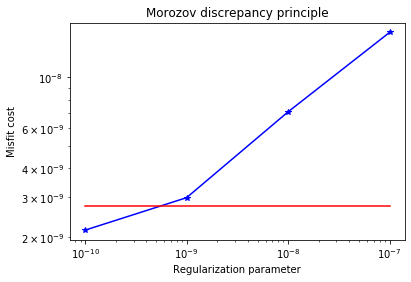

Solve for gamma =  1e-09


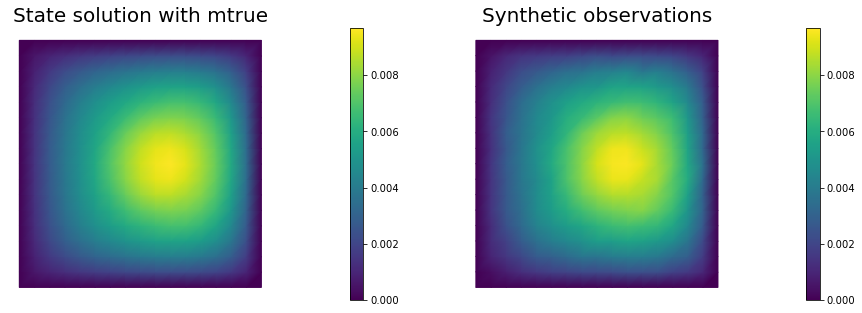

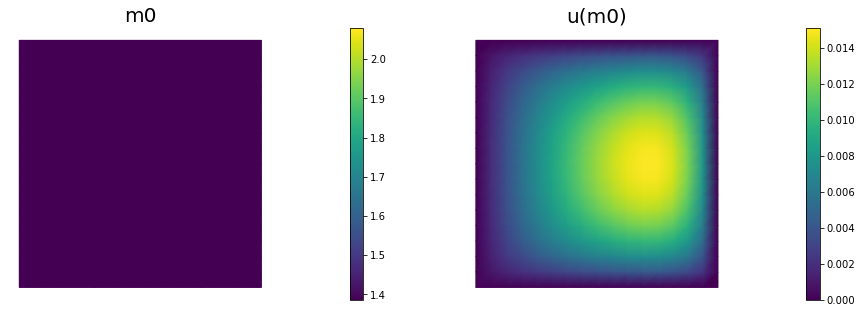

Steepest descent converged in  139   iterations


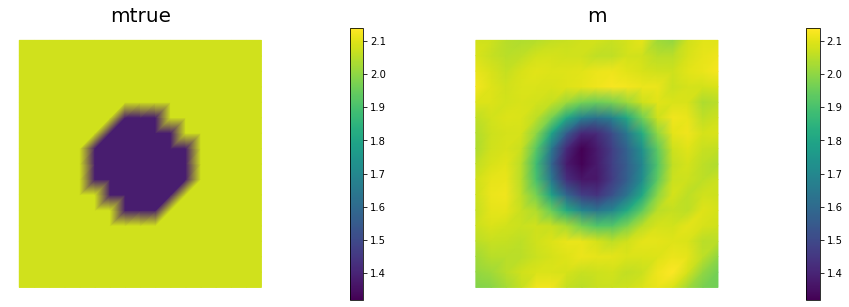

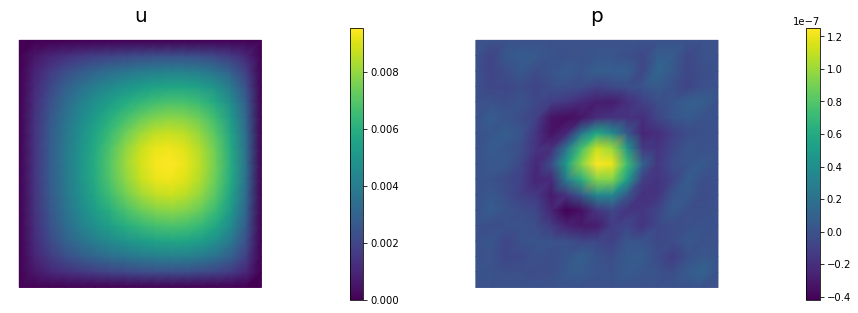

In [14]:
n = 16
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
misfits = []

for gamma in gammas:
    ndof, niter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)),
                                         gamma = gamma, useTV=False, plotting=False)
    misfits.append(misfit)
    
plt.loglog(gammas, misfits, "-*b", label="Misfit")
plt.loglog([gammas[0],gammas[-1]], [.5*noise_norm2, .5*noise_norm2], "-r", label="Squared norm noise")
plt.title("Morozov discrepancy principle")
plt.xlabel("Regularization parameter")
plt.ylabel("Misfit cost")
plt.show()

print("Solve for gamma = ", 1e-9)
_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)), gamma = 1e-9, useTV=False, plotting=True)

We study the behavior of the algorithm by solving the problem with $8 \times 8$, $16 \times 16$, $32 \times 32$, $64 \times 64$ finite elements. We observe that the number of interations increases as we refine the mesh. Thus, steepest descent method is not scalable with respect to the parameter dimension.

Steepest descent converged in  127   iterations
Steepest descent converged in  139   iterations
Steepest descent converged in  541   iterations
Steepest descent converged in  2220   iterations


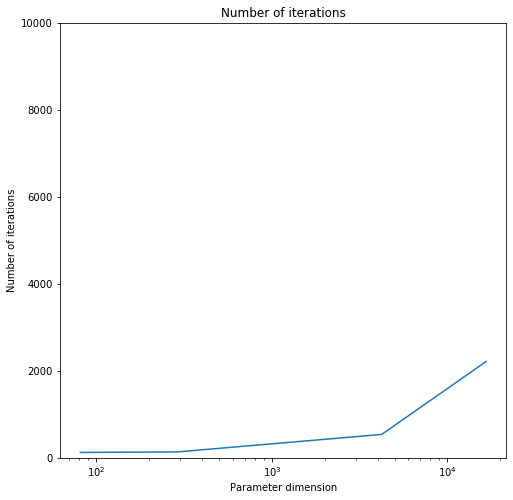

In [27]:
ns = [8, 16, 64, 128]
niters = []
ndofs  = []

for n in ns:
    ndof, niter, _,_,_,_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)),
                                         gamma = 1e-9, useTV=False, plotting=False)
    niters.append(niter)
    ndofs.append(ndof)
    
plt.figure(figsize=(8,8))    
plt.semilogx(ndofs, niters)
plt.ylim([0, 10000])
plt.title("Number of iterations")
plt.xlabel("Parameter dimension")
plt.ylabel("Number of iterations")
plt.show()

## Total Variation regularization

Since the coefficient $m$ is discontinuous, a better choice of regularization is Total Variation (TV) rather than Tikhonov regularization, to prevent an overly smooth reconstruction:

$$ \mathcal{R}_{\rm TV}^\varepsilon = \gamma \int_\Omega (\nabla m \cdot \nabla m + \varepsilon)^{\frac{1}{2}}\, dx.
$$
To make the non-differentiable TV regularization term differentiable, we use $\epsilon=0.1$.

Steepest descent converged in  376   iterations
Steepest descent converged in  192   iterations
Steepest descent converged in  267   iterations


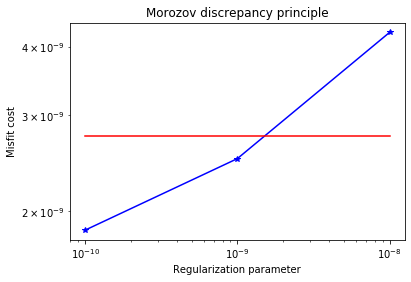

Solve for gamma =  1e-08


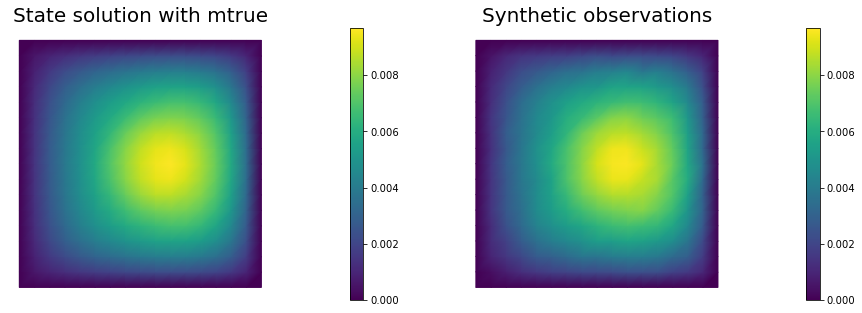

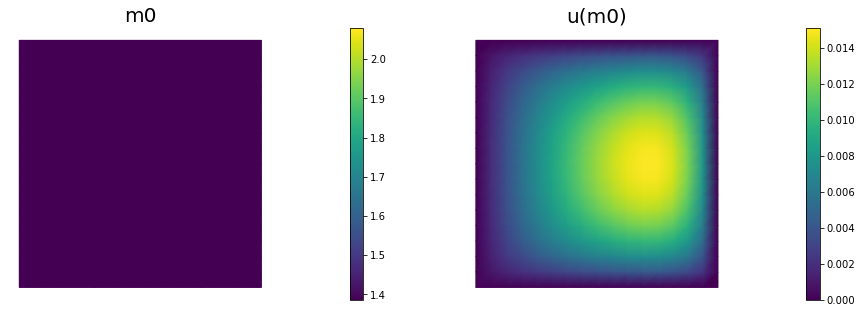

Steepest descent converged in  376   iterations


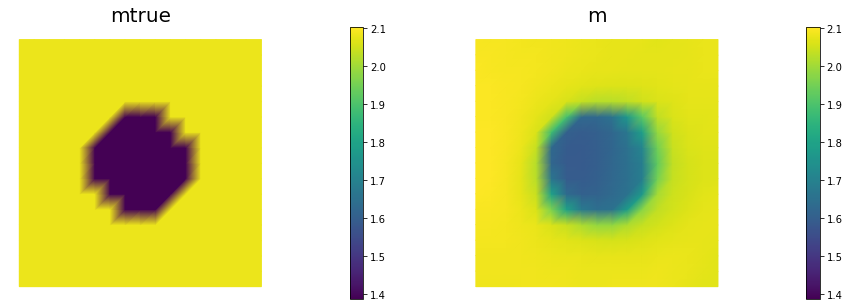

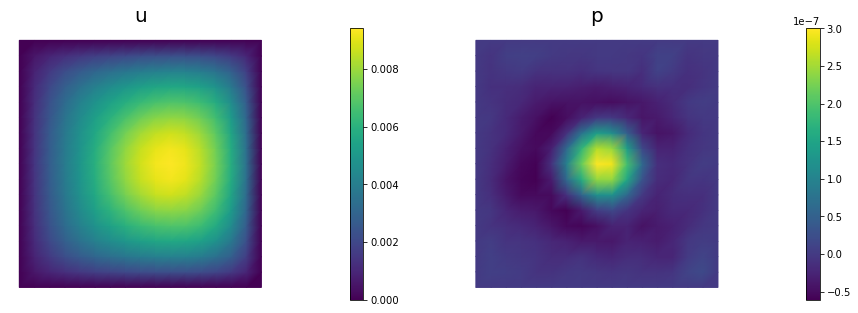

In [17]:
n = 16
gammas = [1e-8, 1e-9, 1e-10]
misfits = []

for gamma in gammas:
    ndof, niter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)),
                                         gamma = gamma, useTV=True, TVeps=dl.Constant(0.1), plotting=False)
    misfits.append(misfit)
    
plt.loglog(gammas, misfits, "-*b", label="Misfit")
plt.loglog([gammas[0],gammas[-1]], [.5*noise_norm2, .5*noise_norm2], "-r", label="Squared norm noise")
plt.title("Morozov discrepancy principle")
plt.xlabel("Regularization parameter")
plt.ylabel("Misfit cost")
plt.show()

print("Solve for gamma = ", 1e-8)
_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)), gamma = 1e-8, useTV=True,
                      TVeps=dl.Constant(0.1), plotting=True)

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright (c) 2019, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.